In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from category_encoders.target_encoder import TargetEncoder

In [42]:
data = pd.read_csv("heart_attack_prediction_dataset.csv")
df=data.copy()
df

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,MSV9918,60,Male,121,94/76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,QSV6764,28,Female,120,157/102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,XKA5925,47,Male,250,161/75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,EPE6801,36,Male,178,119/67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


In [43]:
data = df.copy()

In [44]:
# 1 for Male, 0 for Female
# 1 for Southern Hemisphere, 0 for Northern Hemisphere

le = LabelEncoder()
data[["Sex", "Hemisphere"]] = data[["Sex", "Hemisphere"]].agg(le.fit_transform)

In [45]:
data["Blood_Systolic_Pres"] = data["Blood Pressure"].apply(lambda x: x.split("/")[0]).astype(int)
data["Blood_Diastolic_Pres"] = data["Blood Pressure"].apply(lambda x: x.split("/")[1]).astype(int)
data.drop("Blood Pressure", axis=1, inplace=True)

In [46]:
print(df.columns)

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')


In [47]:
# encode countries by longitude and latitude
world_data = pd.read_csv("world-data-2023.csv")
countries_map = world_data[["Country", "Longitude", "Latitude"]]
data = pd.merge(data, countries_map, on="Country", how="left")

In [48]:
# Binning & Encoding Data
def categorize_blood_pressure(row):
    sys = row['Blood_Systolic_Pres']
    dia = row['Blood_Diastolic_Pres']
    if sys < 120 and dia < 80:
        return 'Low'
    elif (120 <= sys < 130 and dia < 80) or (130 <= sys < 140) or (80 <= dia < 90):
        return 'Medium'
    else:
        return 'High'

data['Blood Pressure'] = data.apply(categorize_blood_pressure, axis=1)

# 5. Bin Cholesterol
def categorize_cholesterol(level):
    if level < 200:
        return 'Average'
    elif 200 <= level < 240:
        return 'Borderline High'
    else:
        return 'High'

data['Cholesterol'] = data['Cholesterol'].apply(categorize_cholesterol)


# 7. Bin Triglycerides
def categorize_triglycerides(level):
    if level < 150:
        return 'Normal'
    elif 150 <= level < 500:
        return 'High'
    else:
        return 'Very High'
        
data['Triglycerides'] = data['Triglycerides'].apply(categorize_triglycerides)


# Create a LabelEncoder object
le = LabelEncoder()

# Encode Blood Pressure
data['Blood Pressure Encoded'] = le.fit_transform(data['Blood Pressure'])

# Encode Cholesterol
data['Cholesterol Encoded'] = le.fit_transform(data['Cholesterol'])

# Encode Triglycerides
data['Triglycerides Encoded'] = le.fit_transform(data['Triglycerides'])

#Encode Diet
data['Diet Encoded'] = le.fit_transform(data['Diet'])

# Display the updated DataFrame
data_fin = data.drop(columns= ['Cholesterol','Blood Pressure','Triglycerides', 'Country','Continent','Diet','Patient ID','Blood_Systolic_Pres','Blood_Diastolic_Pres'])
print(data_fin)

      Age  Sex  Heart Rate  Diabetes  Family History  Smoking  Obesity  \
0      67    1          72         0               0        1        0   
1      21    1          98         1               1        1        1   
2      21    0          72         1               0        0        0   
3      84    1          73         1               1        1        0   
4      66    1          93         1               1        1        1   
...   ...  ...         ...       ...             ...      ...      ...   
8758   60    1          61         1               1        1        0   
8759   28    0          73         1               0        0        1   
8760   47    1         105         0               1        1        1   
8761   36    1          60         1               0        1        0   
8762   25    0          75         1               1        0        0   

      Alcohol Consumption  Exercise Hours Per Week  Previous Heart Problems  \
0                       0       

In [49]:
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   int32  
 2   Heart Rate                       8763 non-null   int64  
 3   Diabetes                         8763 non-null   int64  
 4   Family History                   8763 non-null   int64  
 5   Smoking                          8763 non-null   int64  
 6   Obesity                          8763 non-null   int64  
 7   Alcohol Consumption              8763 non-null   int64  
 8   Exercise Hours Per Week          8763 non-null   float64
 9   Previous Heart Problems          8763 non-null   int64  
 10  Medication Use                   8763 non-null   int64  
 11  Stress Level                     8763 non-null   int64  
 12  Sedentary Hours Per 

In [50]:
data_fin.head()

,Age,Sex,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,...,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Longitude,Latitude,Blood Pressure Encoded,Cholesterol Encoded,Triglycerides Encoded,Diet Encoded
0,67,1,72,0,0,1,0,0,4.168189,0,...,0,6,1,0,-63.616672,-38.416097,2,1,0,0
1,21,1,98,1,1,1,1,1,1.813242,1,...,1,7,0,0,-106.346771,56.130366,0,2,0,2
2,21,0,72,1,0,0,0,0,2.078353,1,...,4,4,0,0,2.213749,46.227638,0,2,2,1
3,84,1,73,1,1,1,0,1,9.828130,1,...,3,4,0,0,-106.346771,56.130366,0,2,0,0
4,66,1,93,1,1,1,1,0,5.804299,1,...,1,5,0,0,100.992541,15.870032,2,2,0,2


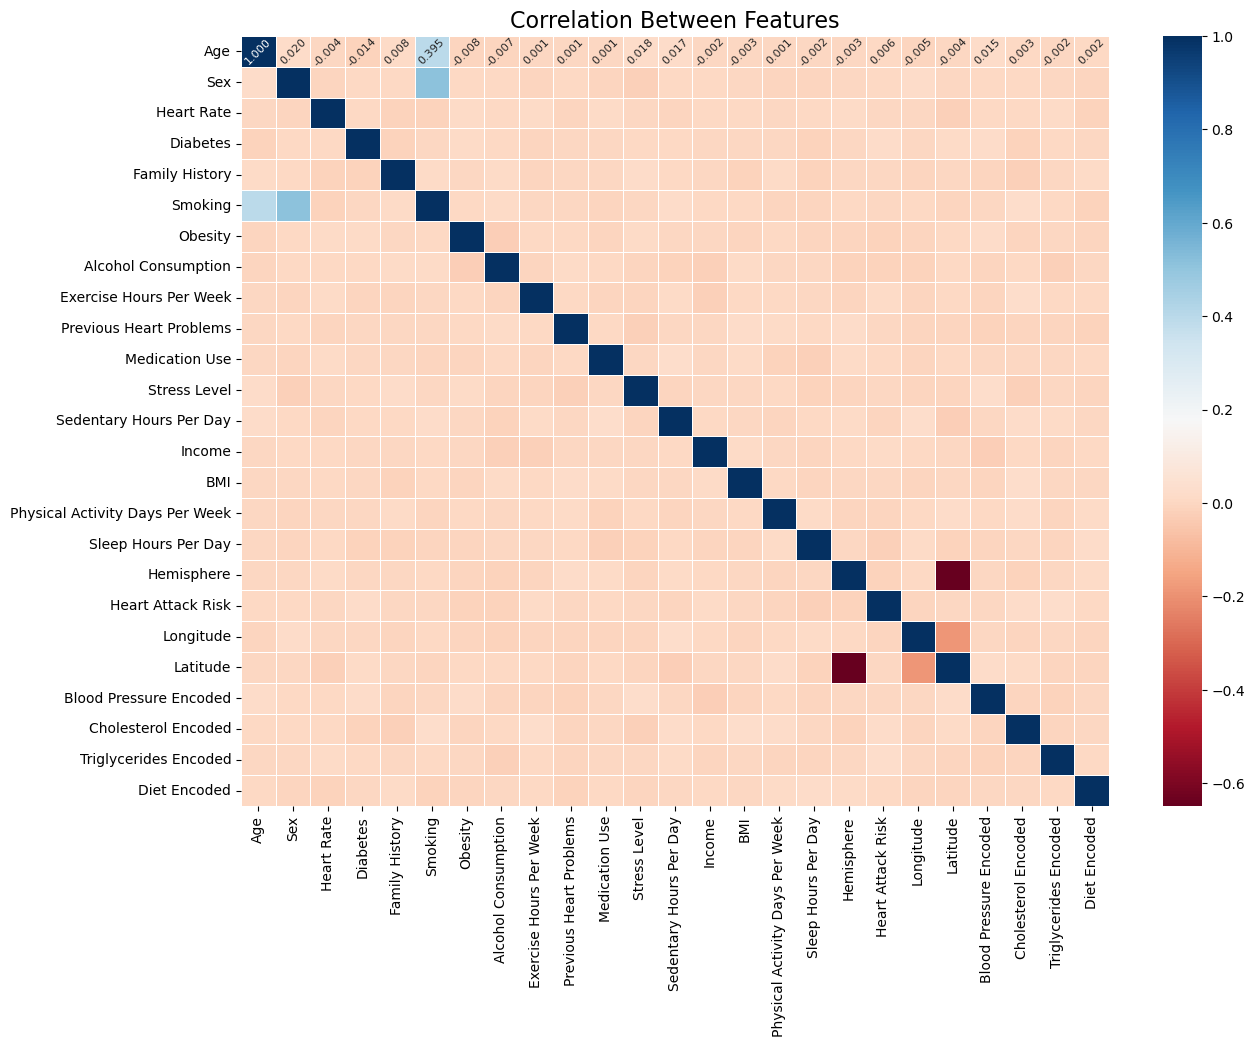

In [51]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Drop categorical columns and calculate the correlation matrix
correlation_matrix = data_fin.corr()

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, linewidths=0.4, fmt='.3f', cmap="RdBu", 
            annot_kws={'size': 8, 'rotation': 45})

# Set the title for the heatmap
plt.title("Correlation Between Features", fontsize=16)

# Display the heatmap
plt.show()

## Prediction Models

### Decision Trees

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO
from IPython.display import Image

In [ ]:
def optimal_clf(X_train, X_test, y_train, y_test):

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5,min_samples_leaf=200, class_weight="balanced")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    best_f1 = f1_score(y_test, y_pred)
    best_accuracy = accuracy_score(y_test, y_pred)

    return [clf, best_f1, best_accuracy]


In [ ]:
def optimal_clf_smote(X_train, X_test, y_train, y_test):
    # best_combined_score = 0
    # best_f1 = 0
    # best_accuracy = 0
    # final_clf = None  # Initialize to None

    # max_depth = 5

    smote = SMOTE(random_state = 42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, 
                                          min_samples_leaf=200)
    clf.fit(X_smote, y_smote)
    y_pred = clf.predict(X_test)
    best_f1 = f1_score(y_test, y_pred)
    best_accuracy = accuracy_score(y_test, y_pred)

    return [clf, best_f1, best_accuracy]


In [56]:
from sklearn.model_selection import StratifiedKFold
def k_folds(X, y):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    f1_scores = []
    accuracies = []
    X_array = X.to_numpy()
    y_array = y.to_numpy()

    for train_index, test_index in kf.split(X_array, y_array):
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_array[train_index], y_array[test_index]

        final_clf = optimal_clf_smote(X_train, X_test, y_train, y_test)

        # Evaluate
        f1_scores.append(final_clf[1])
        accuracies.append(final_clf[2])

    print(f'Average F1 Score: {np.mean(f1_scores)}, Std Dev F1 Score: {np.std(f1_scores)}')
    print(f'Average Accuracy: {np.mean(accuracies)}, Std Dev Accuracy: {np.std(accuracies)}')

In [57]:
# 1st decision tree: geographical factors
X = data_fin[["Longitude", "Latitude", "Hemisphere"]]
y = data_fin["Heart Attack Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
initial_clf = optimal_clf(X_train, X_test, y_train, y_test)

print("Before SMOTE")
print("Accuracy: " + str(initial_clf[2]))
print("F1 score: " + str(initial_clf[1]))

Before SMOTE
Accuracy: 0.4945807187678266
F1 score: 0.39891451831750346


In [58]:
final_clf = optimal_clf_smote(X_train, X_test, y_train, y_test)


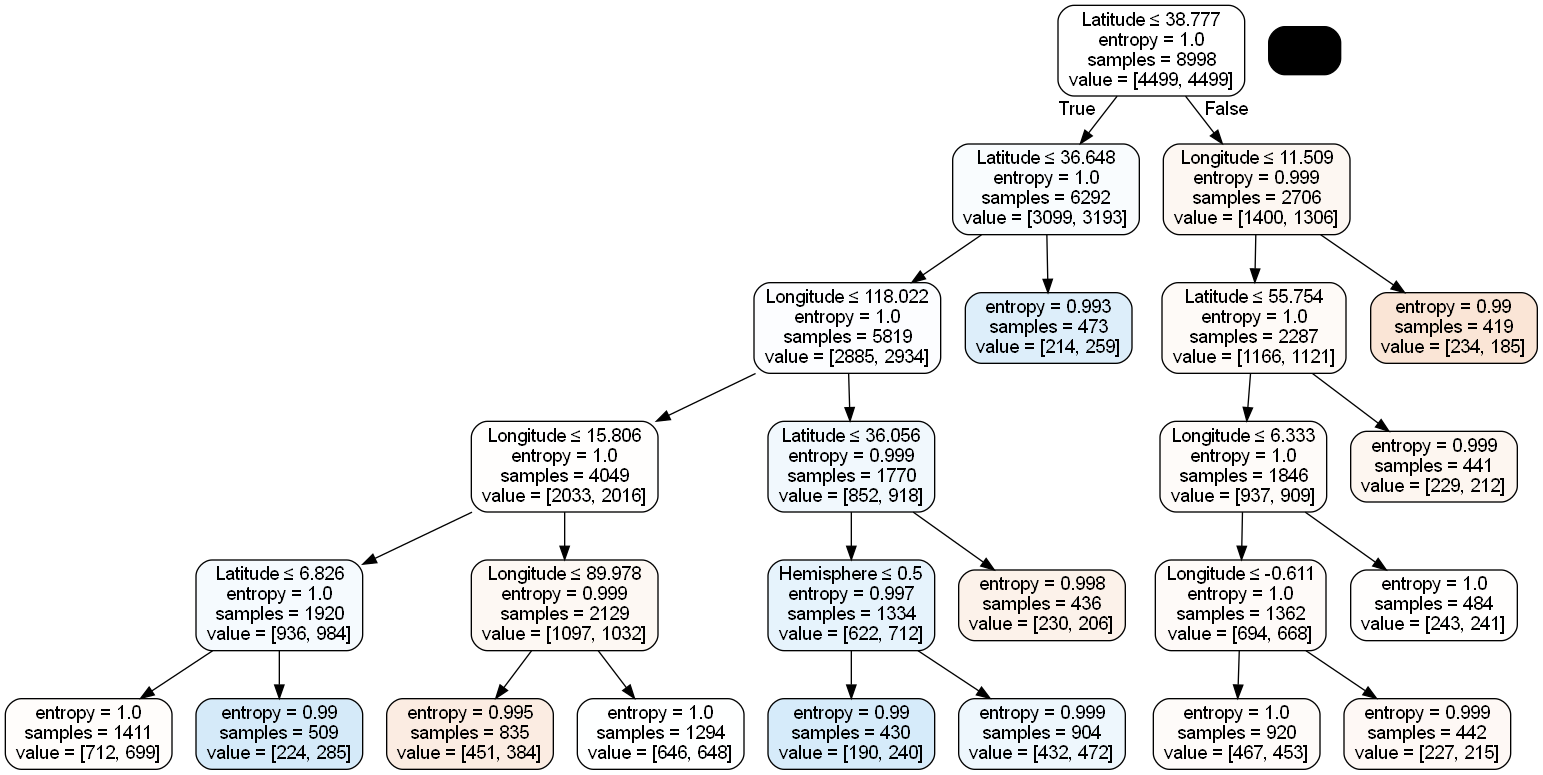

In [59]:
feature_cols = ["Longitude", "Latitude", "Hemisphere"]

dot_data = StringIO()
export_graphviz(final_clf[0], out_file = dot_data,
                feature_names = feature_cols,
                filled = True, rounded = True,
                special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [61]:
y_pred = final_clf[0].predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("\nAfter SMOTE:")
print("Accuracy: " + str(final_clf[2]))
print("F1 score: " + str(final_clf[1]))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1125
           1       0.33      0.36      0.35       628

    accuracy                           0.51      1753
   macro avg       0.48      0.48      0.48      1753
weighted avg       0.52      0.51      0.52      1753

[[671 454]
 [401 227]]

After SMOTE:
Accuracy: 0.5122646891043925
F1 score: 0.34682964094728796


In [62]:
k_folds(X, y)

Average F1 Score: 0.42474298004760397, Std Dev F1 Score: 0.03020671746653396
Average Accuracy: 0.4995978192635196, Std Dev Accuracy: 0.018975482472600436


In [63]:
# 2nd decision tree: health factors

X = data_fin[["Cholesterol Encoded", "Blood Pressure Encoded", "Heart Rate", 
          "Diabetes", "Obesity", 
          "Previous Heart Problems", "BMI"]]
y = data_fin["Heart Attack Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
initial_clf = optimal_clf(X_train, X_test, y_train, y_test)
print("Before SMOTE:")
print("Accuracy: " + str(initial_clf[2]))
print("F1 score: " + str(initial_clf[1]))


Before SMOTE:
Accuracy: 0.46263548203080435
F1 score: 0.5042105263157896


In [64]:
final_clf = optimal_clf_smote(X_train, X_test, y_train, y_test)

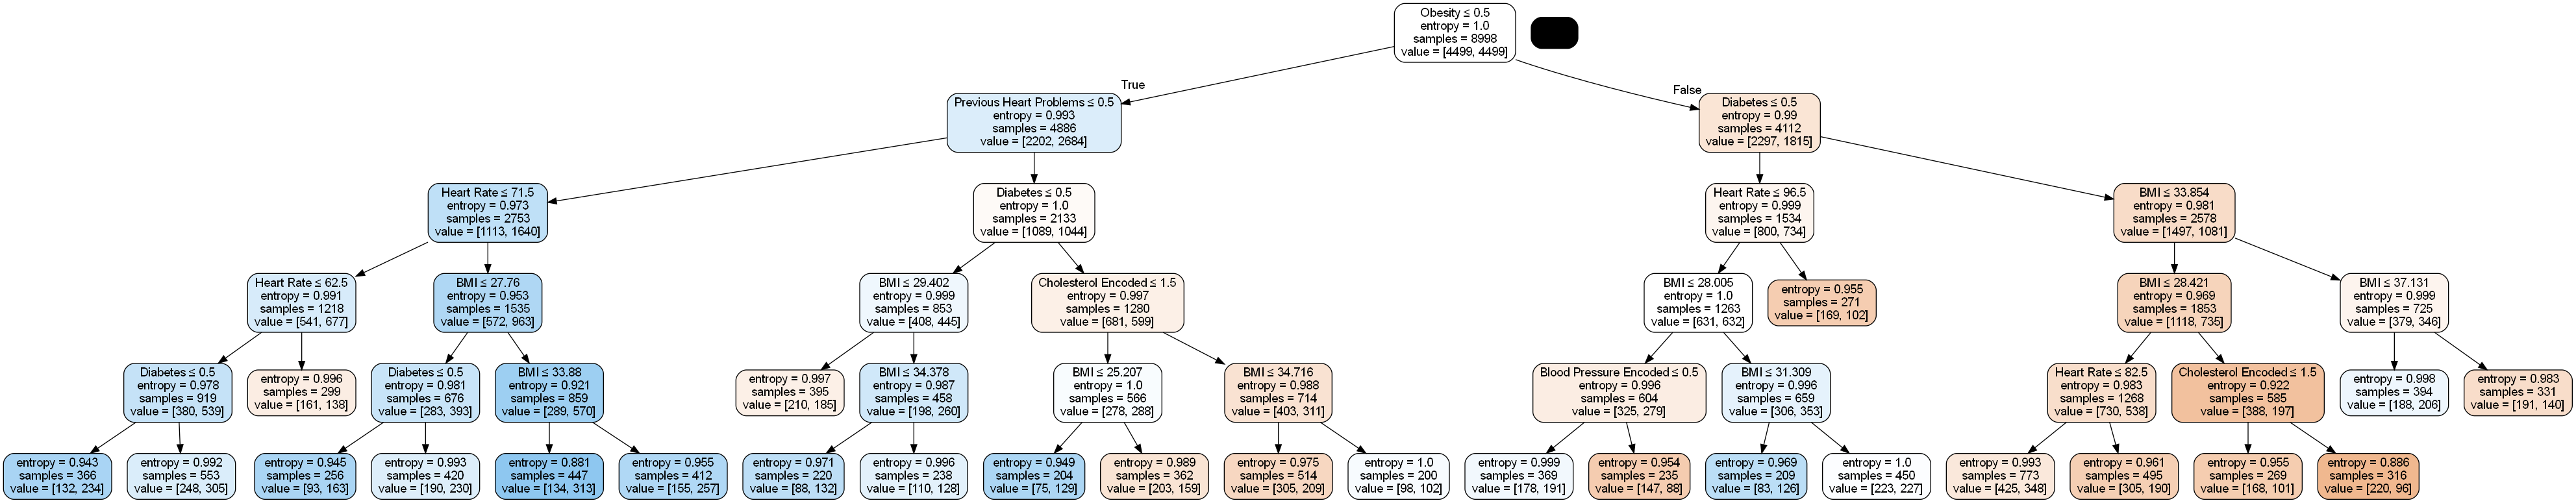

In [65]:
feature_cols = ["Cholesterol Encoded", "Blood Pressure Encoded", "Heart Rate", "Diabetes", "Obesity", "Previous Heart Problems", "BMI"]

dot_data = StringIO()
export_graphviz(final_clf[0], out_file = dot_data,
                feature_names = feature_cols,
                filled = True, rounded = True,
                special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [67]:
y_pred = final_clf[0].predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("\nAfter SMOTE:")
print("Accuracy: " + str(final_clf[2]))
print("F1 score: " + str(final_clf[1]))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1125
           1       0.36      0.46      0.40       628

    accuracy                           0.51      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.51      0.52      1753

[[600 525]
 [338 290]]

After SMOTE:
Accuracy: 0.5077010838562465
F1 score: 0.401940401940402


In [68]:
k_folds(X, y)

Average F1 Score: 0.1402143799549857, Std Dev F1 Score: 0.042324702871833444
Average Accuracy: 0.6147436749004316, Std Dev Accuracy: 0.008060411041252179


In [69]:
# 3rd decision tree: lifestyle factors

X = data[["Smoking", 'Exercise Hours Per Week', 
          'Sedentary Hours Per Day', 
          'Physical Activity Days Per Week', 
          'Sleep Hours Per Day', 'Smoking', 
          'Alcohol Consumption', 'Diet Encoded']]
y = data["Heart Attack Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
initial_clf = optimal_clf(X_train, X_test, y_train, y_test)
print("Before SMOTE:")
print("Accuracy: " + str(initial_clf[2]))
print("F1 score: " + str(initial_clf[1]))


Before SMOTE:
Accuracy: 0.4112949229891614
F1 score: 0.4896142433234422


In [70]:
final_clf = optimal_clf_smote(X_train, X_test, y_train, y_test)

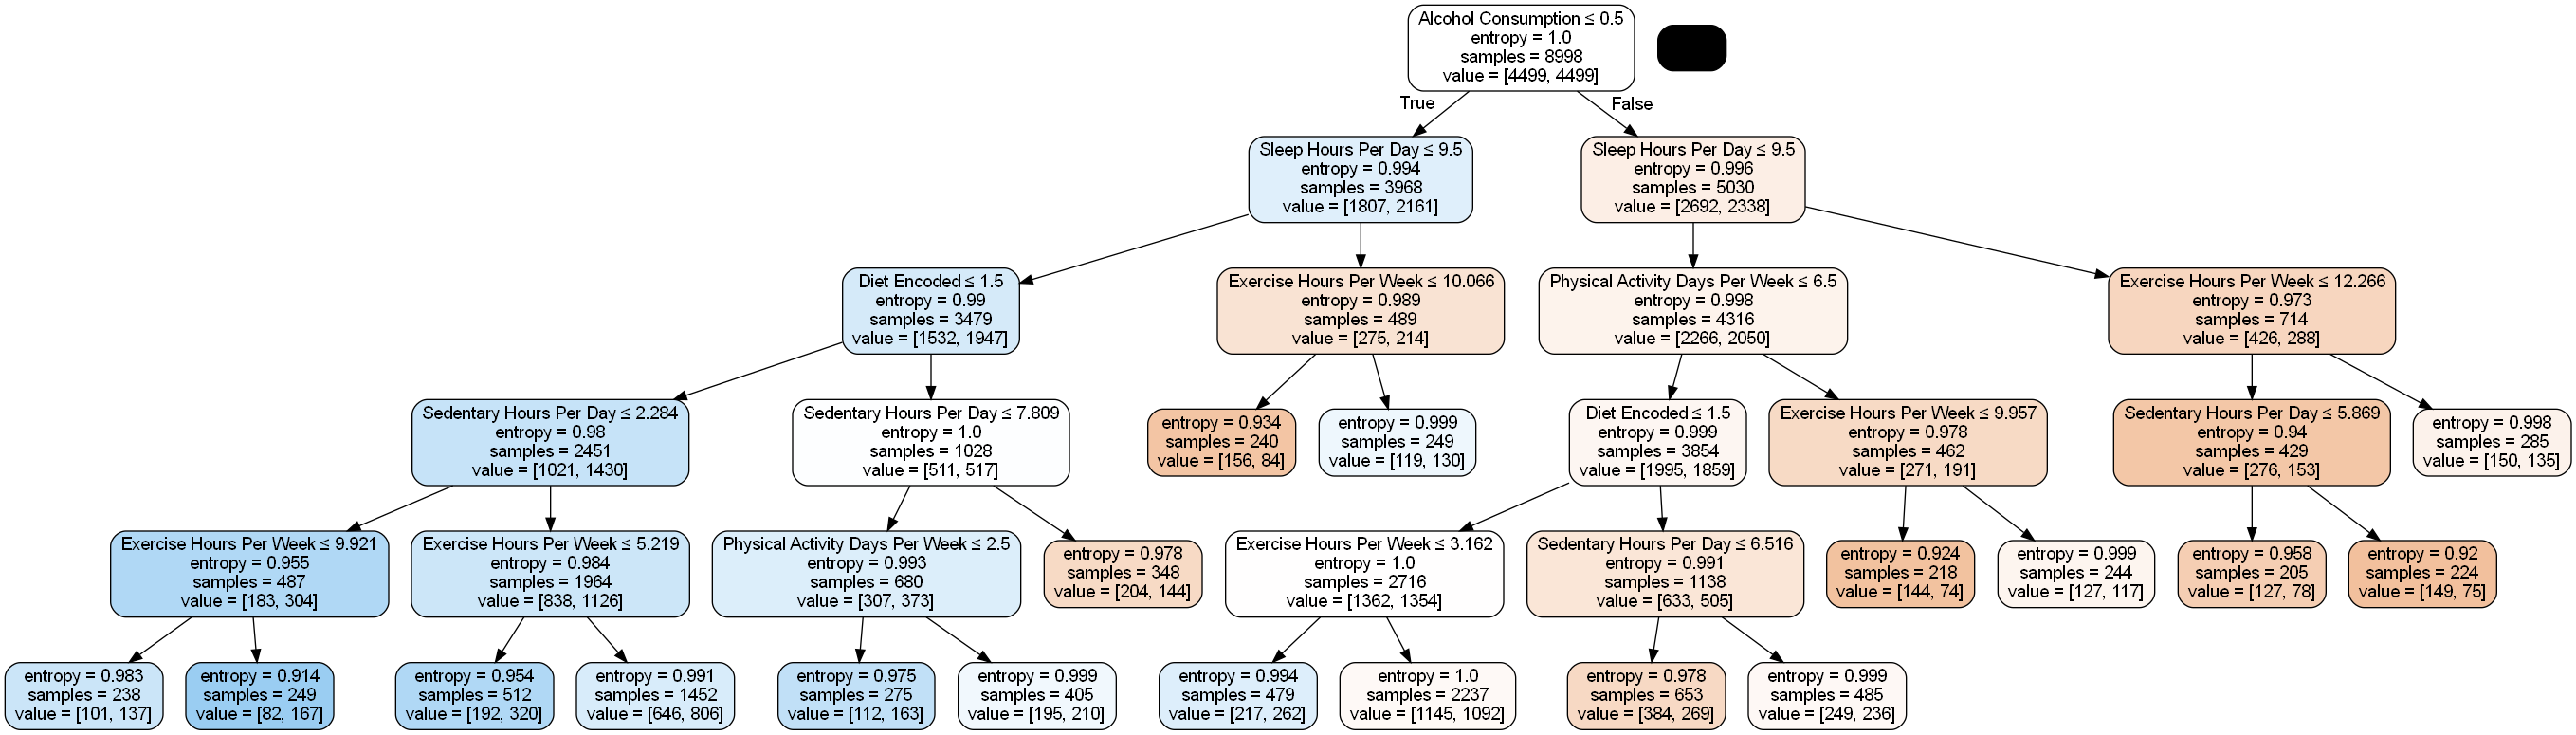

In [71]:
feature_cols = ["Smoking", 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Physical Activity Days Per Week', 
          'Sleep Hours Per Day', 'Smoking', 'Alcohol Consumption', 'Diet Encoded']

dot_data = StringIO()
export_graphviz(final_clf[0], out_file = dot_data,
                feature_names = feature_cols,
                filled = True, rounded = True,
                special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [73]:
y_pred = final_clf[0].predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("\nAfter SMOTE")
print("Accuracy: " + str(final_clf[2]))
print("F1 score: " + str(final_clf[1]))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1125
           1       0.38      0.39      0.38       628

    accuracy                           0.55      1753
   macro avg       0.51      0.51      0.51      1753
weighted avg       0.55      0.55      0.55      1753

[[723 402]
 [386 242]]

After SMOTE
Accuracy: 0.5504848830576156
F1 score: 0.3805031446540881


In [74]:
k_folds(X, y)

Average F1 Score: 0.20279376748554528, Std Dev F1 Score: 0.09079590144633597
Average Accuracy: 0.5913495976890236, Std Dev Accuracy: 0.021392768364291156


In [75]:
# 4th decision tree: all factors
X = data_fin.drop(columns=['Heart Attack Risk'])
y = data_fin['Heart Attack Risk']  

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_smote, y_smote = smote.fit_resample(X, y)

In [76]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, 
                                          min_samples_leaf=200, class_weight={0: 1, 1: 1.7})
clf.fit(X_smote, y_smote)

DecisionTreeClassifier(class_weight={0: 1, 1: 1.7}, criterion='entropy',
                       max_depth=5, min_samples_leaf=200)

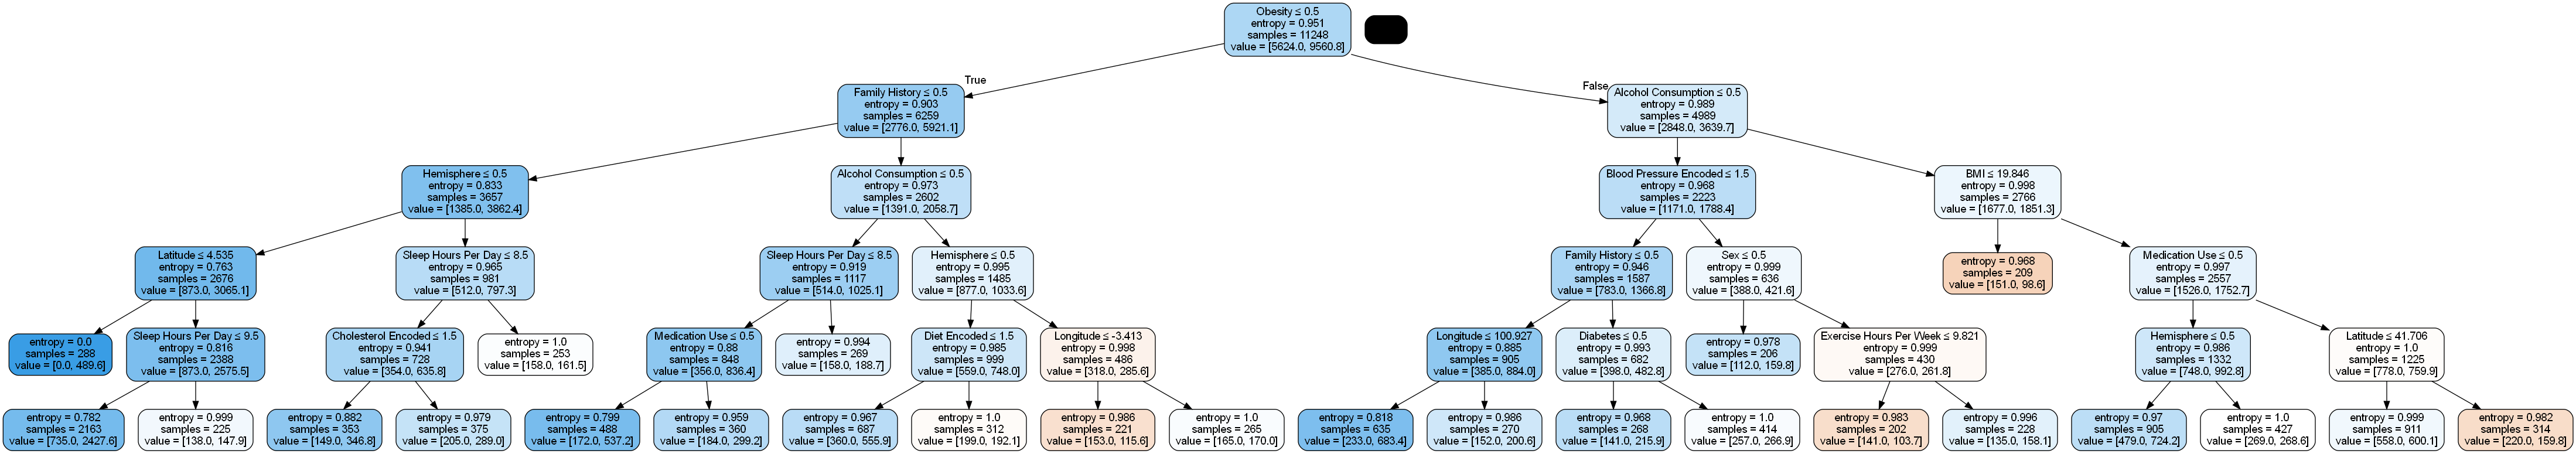

In [77]:
dot_data = StringIO()
export_graphviz(clf, out_file = dot_data,
                feature_names = X.columns,
                filled = True, rounded = True,
                special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [78]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("Accuracy: " + str(final_clf[2]))
print("F1 score: " + str(final_clf[1]))

              precision    recall  f1-score   support

           0       0.65      0.19      0.29      1125
           1       0.36      0.82      0.50       628

    accuracy                           0.41      1753
   macro avg       0.51      0.50      0.40      1753
weighted avg       0.55      0.41      0.37      1753

[[211 914]
 [113 515]]
Accuracy: 0.5504848830576156
F1 score: 0.3805031446540881


In [79]:
k_folds(X, y)

Average F1 Score: 0.12942441359616597, Std Dev F1 Score: 0.0737607653110426
Average Accuracy: 0.6217098151375202, Std Dev Accuracy: 0.02547359883678298
